In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from scipy.special import expit

from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_recall_curve, roc_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from fart.common.constants import (
    BBANDS_LOWER,
    BBANDS_MIDDLE,
    BBANDS_UPPER,
    CLOSE,
    EMA_FAST,
    EMA_SLOW,
    HIGH,
    HONOLULU_BLUE,
    LOW,
    MACD_HISTOGRAM,
    MACD_SIGNAL,
    MACD,
    OPEN,
    RSI,
    TIMESTAMP,
    VOLUME,
)
from fart.features.calculate_technical_indicators import calculate_technical_indicators
from fart.model.train_test_split import train_test_split

In [2]:
df = pl.read_csv("../data/BTC-EUR.csv")
df = calculate_technical_indicators(df)

In [3]:
features = [
    CLOSE,
    BBANDS_LOWER,
    BBANDS_MIDDLE,
    BBANDS_UPPER,
    EMA_FAST,
    EMA_SLOW,
    MACD,
    MACD_SIGNAL,
    MACD_HISTOGRAM,
    RSI,
]
lags = range(1, 4)

df = df.with_columns(
    [
        pl.col(col).shift(lag).alias(f"{col} #{lag}")
        for lag in lags
        for col in features
    ]
)

df = df.drop_nans()

In [4]:
columns = [
    BBANDS_LOWER,
    BBANDS_MIDDLE,
    BBANDS_UPPER,
    EMA_FAST,
    EMA_SLOW,
    HIGH,
    LOW,
    MACD_HISTOGRAM,
    MACD_SIGNAL,
    MACD,
    OPEN,
    RSI,
    TIMESTAMP,
    VOLUME,
]

for column in columns:
    if column in df.columns:
        df = df.drop(column)

df.head()

Close,Close #1,Bollinger Bands: Lower #1,Bollinger Bands: Middle #1,Bollinger Bands: Upper #1,Exponential Moving Average: Fast #1,Exponential Moving Average: Slow #1,Moving Average Convergence Divergence #1,Moving Average Convergence Divergence: Signal #1,Moving Average Convergence Divergence: Histogram #1,Relative Strength Index #1,Close #2,Bollinger Bands: Lower #2,Bollinger Bands: Middle #2,Bollinger Bands: Upper #2,Exponential Moving Average: Fast #2,Exponential Moving Average: Slow #2,Moving Average Convergence Divergence #2,Moving Average Convergence Divergence: Signal #2,Moving Average Convergence Divergence: Histogram #2,Relative Strength Index #2,Close #3,Bollinger Bands: Lower #3,Bollinger Bands: Middle #3,Bollinger Bands: Upper #3,Exponential Moving Average: Fast #3,Exponential Moving Average: Slow #3,Moving Average Convergence Divergence #3,Moving Average Convergence Divergence: Signal #3,Moving Average Convergence Divergence: Histogram #3,Relative Strength Index #3
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3474.1,3471.6,3403.403621,3448.435,3493.466379,3454.758014,3451.231316,0.251117,-4.779628,5.030745,59.248048,3464.8,3403.590266,3448.225,3492.859734,3450.547517,3449.194448,-1.530054,-6.037314,4.50726,56.832788,3474.5,3403.585329,3448.235,3492.884671,3446.984397,3447.633893,-3.088858,-7.164129,4.075272,61.674505
3474.8,3474.1,3402.981849,3449.045,3495.108151,3458.626411,3453.310287,1.843191,-3.455064,5.298255,60.131247,3471.6,3403.403621,3448.435,3493.466379,3454.758014,3451.231316,0.251117,-4.779628,5.030745,59.248048,3464.8,3403.590266,3448.225,3492.859734,3450.547517,3449.194448,-1.530054,-6.037314,4.50726,56.832788
3474.9,3474.8,3402.608057,3449.52,3496.431943,3461.861129,3455.263898,3.125377,-2.138976,5.264353,60.390102,3474.1,3402.981849,3449.045,3495.108151,3458.626411,3453.310287,1.843191,-3.455064,5.298255,60.131247,3471.6,3403.403621,3448.435,3493.466379,3454.758014,3451.231316,0.251117,-4.779628,5.030745,59.248048
3469.9,3474.9,3402.244712,3450.09,3497.935288,3464.468903,3457.048998,4.102299,-0.890721,4.99302,60.429628,3474.8,3402.608057,3449.52,3496.431943,3461.861129,3455.263898,3.125377,-2.138976,5.264353,60.390102,3474.1,3402.981849,3449.045,3495.108151,3458.626411,3453.310287,1.843191,-3.455064,5.298255,60.131247
3473.0,3469.9,3402.13222,3450.365,3498.59778,3465.555122,3458.217271,4.422084,0.17184,4.250244,57.348204,3474.9,3402.244712,3450.09,3497.935288,3464.468903,3457.048998,4.102299,-0.890721,4.99302,60.429628,3474.8,3402.608057,3449.52,3496.431943,3461.861129,3455.263898,3.125377,-2.138976,5.264353,60.390102


In [5]:
X_train, X_test, y_train, y_test = train_test_split(df)

current_prices = X_test[f"{CLOSE} #1"].values
y_test_directions = (y_test.values > current_prices).astype(int)

In [6]:
class RegressionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, regressor):
        self.regressor = regressor

    def fit(self, X, y):
        self.regressor.fit(X, y)
        return self

    def transform(self, X):
        return self.regressor.predict(X).reshape(-1, 1)

In [7]:
class CurrencyMovementClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, current_prices):
        self.current_prices = current_prices

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return (X.reshape(-1) > self.current_prices).astype(int)
    
    def predict_proba(self, X):
        diff = X.reshape(-1) - self.current_prices
        probs_up = expit(diff)
        probs_down = 1 - probs_up

        return np.vstack([probs_down, probs_up]).T


In [8]:
preprocessor = make_pipeline(
    StandardScaler()
)

postprocessor = make_pipeline(
    CurrencyMovementClassifier(current_prices=current_prices),
)

In [9]:
knn_regressor = make_pipeline(preprocessor, RegressionTransformer(KNeighborsRegressor(n_neighbors=10)), postprocessor)
knn_regressor.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('standardscaler', StandardScaler())])),
                ('regressiontransformer',
                 RegressionTransformer(regressor=KNeighborsRegressor(n_neighbors=10))),
                ('pipeline-2',
                 Pipeline(steps=[('currencymovementclassifier',
                                  CurrencyMovementClassifier(current_prices=array([39153., 39190., 39089., ..., 91245., 91455., 91151.])))]))])

In [10]:
linear_regressor = make_pipeline(preprocessor, RegressionTransformer(LinearRegression()), postprocessor)
linear_regressor.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('standardscaler', StandardScaler())])),
                ('regressiontransformer',
                 RegressionTransformer(regressor=LinearRegression())),
                ('pipeline-2',
                 Pipeline(steps=[('currencymovementclassifier',
                                  CurrencyMovementClassifier(current_prices=array([39153., 39190., 39089., ..., 91245., 91455., 91151.])))]))])

In [11]:
random_forest_regressor = make_pipeline(preprocessor, RegressionTransformer(RandomForestRegressor(random_state=42)), postprocessor)
random_forest_regressor.fit(X_train, y_train)

Pipeline(steps=[('pipeline-1',
                 Pipeline(steps=[('standardscaler', StandardScaler())])),
                ('regressiontransformer',
                 RegressionTransformer(regressor=RandomForestRegressor(random_state=42))),
                ('pipeline-2',
                 Pipeline(steps=[('currencymovementclassifier',
                                  CurrencyMovementClassifier(current_prices=array([39153., 39190., 39089., ..., 91245., 91455., 91151.])))]))])

In [12]:
model_predictions = [
    ["K-Nearest Neighbors Regressor", knn_regressor.predict(X_test)],
    ["Linear Regressor", linear_regressor.predict(X_test)],
    ["Random Forest Regressor", random_forest_regressor.predict(X_test)],
]

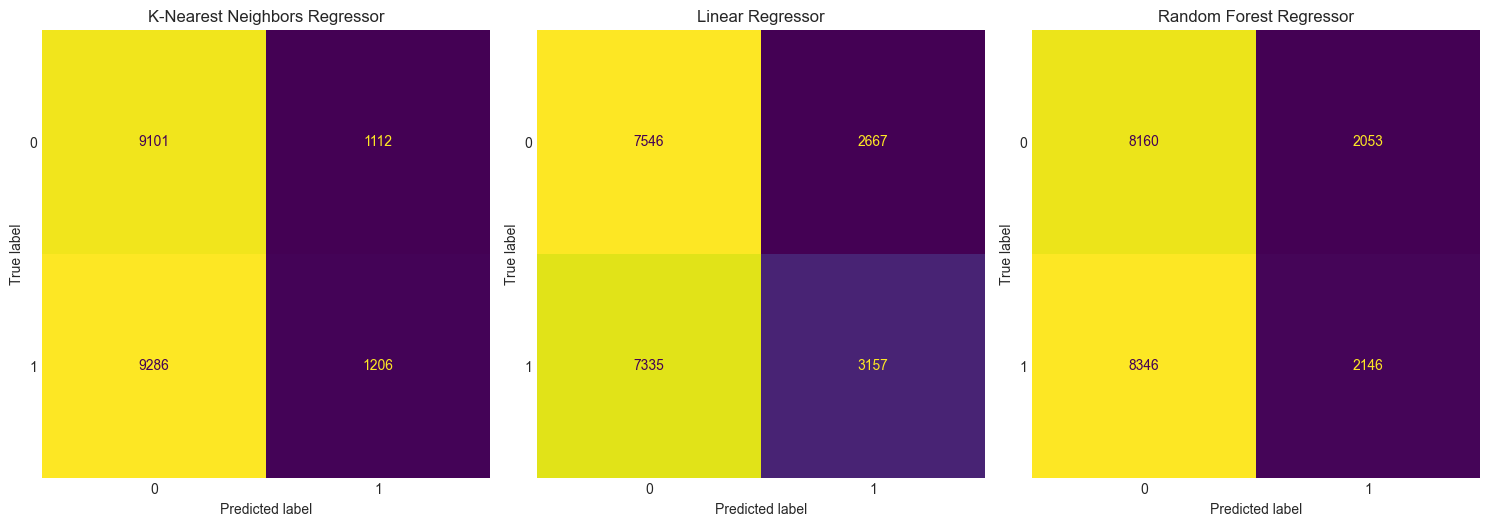

In [13]:
plt.style.use("seaborn-v0_8-dark")

_, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (model_name, predictions) in zip(axes, model_predictions):
    ConfusionMatrixDisplay.from_predictions(
        y_test_directions,
        predictions,
        ax=ax,
        colorbar=False,
    )
    ax.set_title(model_name)


plt.tight_layout()
plt.show()

In [14]:
for model_name, predictions in model_predictions:
    print(f"{model_name}\n")
    print(classification_report(y_test_directions, predictions, zero_division=1))
    print("-" * 54)
    print()

K-Nearest Neighbors Regressor

              precision    recall  f1-score   support

           0       0.49      0.89      0.64     10213
           1       0.52      0.11      0.19     10492

    accuracy                           0.50     20705
   macro avg       0.51      0.50      0.41     20705
weighted avg       0.51      0.50      0.41     20705

------------------------------------------------------

Linear Regressor

              precision    recall  f1-score   support

           0       0.51      0.74      0.60     10213
           1       0.54      0.30      0.39     10492

    accuracy                           0.52     20705
   macro avg       0.52      0.52      0.49     20705
weighted avg       0.52      0.52      0.49     20705

------------------------------------------------------

Random Forest Regressor

              precision    recall  f1-score   support

           0       0.49      0.80      0.61     10213
           1       0.51      0.20      0.29     104

In [15]:
model_probabilities = [
    ["K-Nearest Neighbors Regressor", knn_regressor.predict_proba(X_test)[:, 1]],
    ["Linear Regressor", linear_regressor.predict_proba(X_test)[:, 1]],
    ["Random Forest Regressor", random_forest_regressor.predict_proba(X_test)[:, 1]],
]

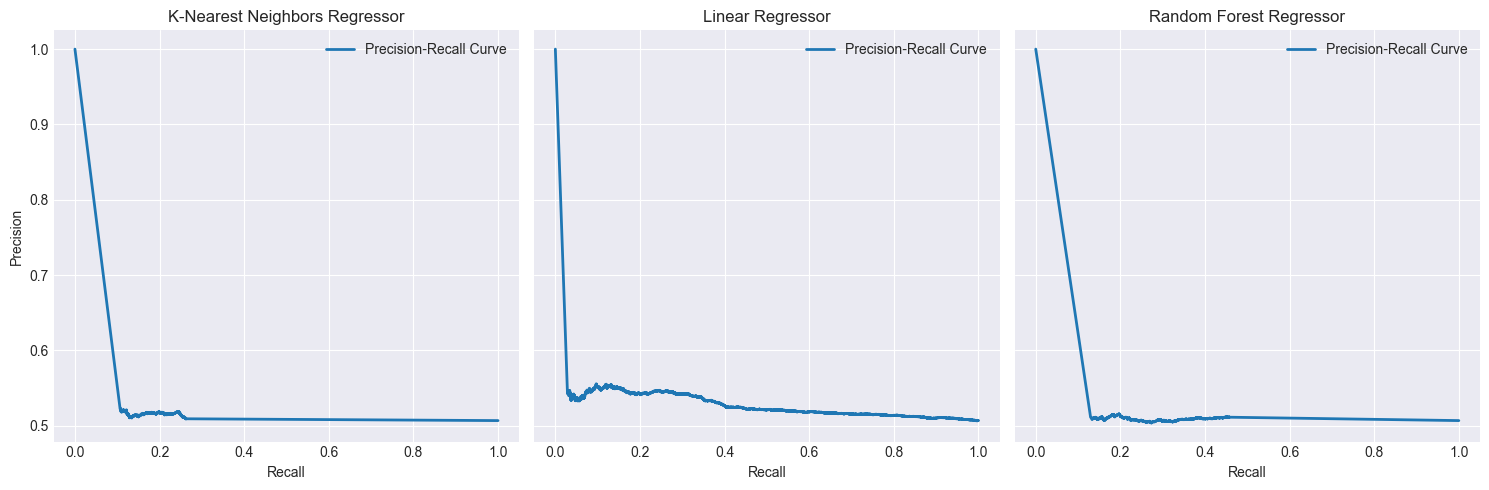

In [16]:
plt.style.use("seaborn-v0_8-darkgrid")

_, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (model_name, probabilities) in zip(axes, model_probabilities):
    precisions, recalls, thresholds = precision_recall_curve(y_test_directions, probabilities)

    ax.plot(recalls, precisions, label="Precision-Recall Curve", linewidth=2, color=HONOLULU_BLUE)
    ax.set_xlabel("Recall")
    ax.set_title(model_name)
    ax.legend()

axes[0].set_ylabel("Precision")

plt.tight_layout()
plt.show()

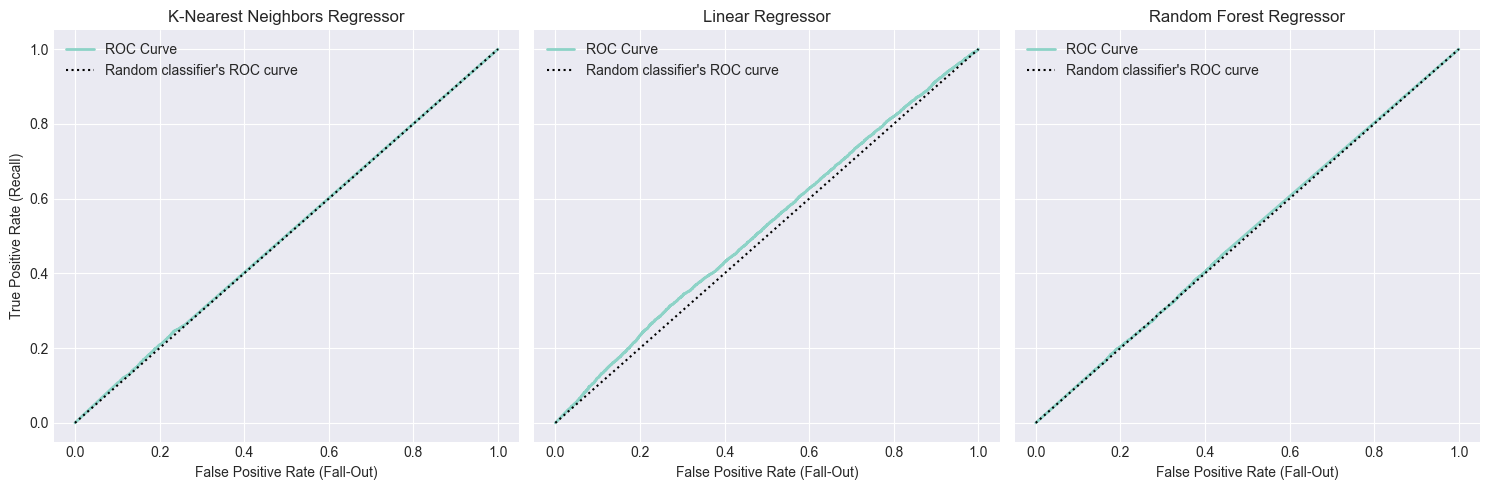

In [17]:
plt.style.use("seaborn-v0_8-darkgrid")

_, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (model_name, probabilities) in zip(axes, model_probabilities):
    false_positive_rates, true_positive_rates, thresholds = roc_curve(y_test_directions, probabilities)

    ax.plot(false_positive_rates, true_positive_rates, label="ROC Curve", linewidth=2)
    ax.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
    ax.set_xlabel("False Positive Rate (Fall-Out)")
    
    ax.set_title(model_name)
    ax.legend()

axes[0].set_ylabel("True Positive Rate (Recall)")

plt.tight_layout()
plt.show()

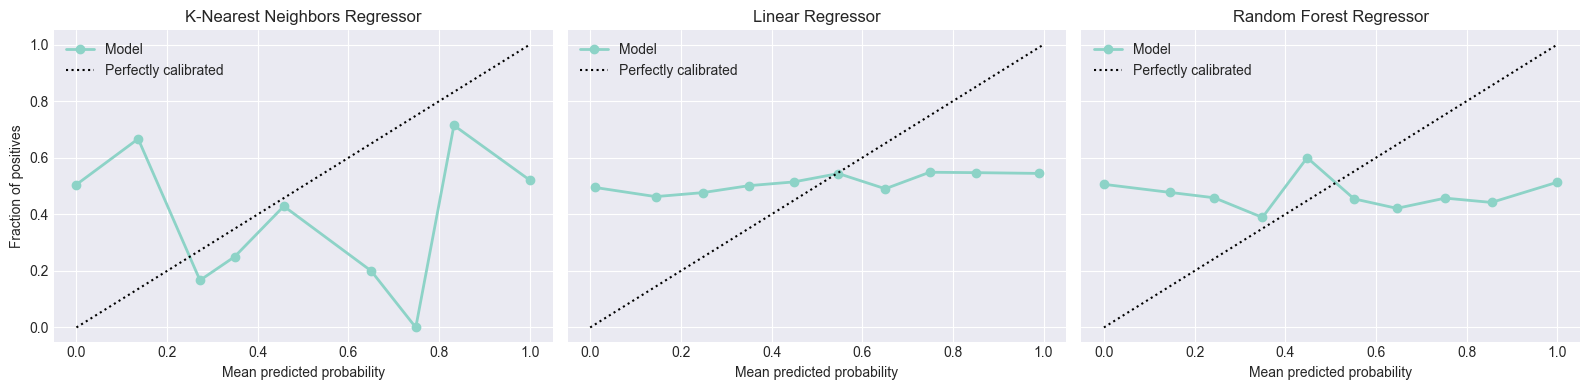

In [18]:
plt.style.use("seaborn-v0_8-darkgrid")

_, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for ax, (model_name, probabilities) in zip(axes, model_probabilities):
    prob_true, prob_pred = calibration_curve(y_test_directions, probabilities, n_bins=10)

    ax.plot(prob_pred, prob_true, marker="o", label="Model", linewidth=2)
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax.set_xlabel("Mean predicted probability")
    ax.set_title(model_name)
    ax.legend()

axes[0].set_ylabel("Fraction of positives")

plt.tight_layout()
plt.show()